# One-dimensional optimal interpolation example

Optimal interpolation (or Kriging) is a type of Gaussian Process (GP) regression. The internet is full of useful resources on this topic. See for example:

 - the Rasmussen and Williams textbook http://www.gaussianprocess.org/gpml/
 - this nice blog http://krasserm.github.io/2018/03/19/gaussian-processes/
 - Examples from one of the *many* GP software packages: https://en.wikipedia.org/wiki/Comparison_of_Gaussian_process_software

In this notebook, we will use the `OceanOI` package to:

 - Create some test data using a covariance function
 - Estimate the parameters of the dataset
 - Plot the results
 - Change the covariance function
 
---

Matt Rayson

University of Western Australia

August 2021

In [1]:
from oceanoi import cov, oi, driveroi
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
np.random.seed(1) # this generates the same output every time
# Generate some training data

####
# Change these parameters here
noise = 0.1
η = 1.
ℓ = 100
covfunc = cov.expquad_1d
####

covparams = (η, ℓ)


dx = 25.
N = 100
xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*10)

K = covfunc(xd[:,None], xd[:,None].T, covparams)


mu = np.zeros_like(xd)
yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()
yd += noise*np.random.normal(size=(N,))
yd.shape
plt.figure()
plt.plot(xd, yd,'.')
dx

25.0

# Create a 1D OI/GP object and interpolate 

This just demonstrates how the interpolation works

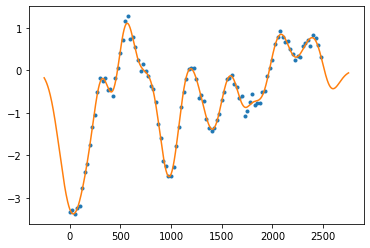

In [3]:
scale = 1

OI = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            noise, covfunc, covparams)

yoi = OI(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')

# Optimise parameters with no priors

In [4]:
covic = (1.5, 0.5, 12)
soln = driveroi.optimise_1d_oi(xd, yd, covfunc, covic)
print('Initial guess:')
print(covic)
print('Optimised parameters:')
print(soln['x'])
print('"True" parameters:')
print((noise,η, ℓ))


Initial guess:
(1.5, 0.5, 12)
Optimised parameters:
[-1.01993174e-01  1.23001260e+00  1.19251703e+02]
"True" parameters:
(0.1, 1.0, 100)


# Optimise parameters with priors


In [5]:
# Here we use scipy.stats random variable distribution functions for each prior
priors = [
    stats.norm(0.2,0.2),
    stats.norm(1,1),
    stats.norm(100,50)
]
bounds =( (0.01, None), (0.01,None), (0.2, None)) 

covic = (0.5, 1, 20)
soln = driveroi.optimise_1d_oi(xd, yd, covfunc, covic, priors=priors,bounds=bounds)
print('Initial guess:')
print(covic)
print('Optimised parameters:')
print(soln['x'])
print('"True" parameters:')
print((noise,η, ℓ))


Initial guess:
(0.5, 1, 20)
Optimised parameters:
[1.02143301e-01 1.21282020e+00 1.18625144e+02]
"True" parameters:
(0.1, 1.0, 100)


In [6]:
# Plot the optimised result
OI = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            noise, covfunc, covparams)
yoi = OI(yd[:,None])

OI2 = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            soln['x'][0], covfunc, soln['x'][1:])
yoi2 = OI2(yd[:,None])

OI3 = oi.OptimalInterp1D(xd*scale,  \
                            xo*scale,\
                            covic[0], covfunc, covic[1:])
yoi3 = OI3(yd[:,None])

plt.figure()
plt.plot(xd, yd,'.')
plt.plot(xo, yoi,'')
plt.plot(xo, yoi2,'')
plt.plot(xo, yoi3,'')
plt.legend(('data','OI True','OI Optimal','OI initial guess'))

# Example of how to build a custom covariance model

Read RM2006 for examples of how covariance kernels can be combined

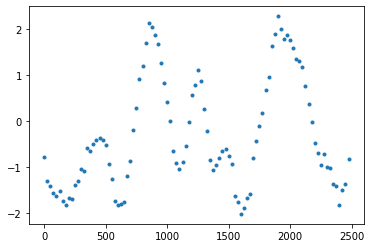

In [7]:
# Combine an exponential quadratic with a cosine kernel --> Spectral mixture model

def spectral(x, xpr, params):
    eta, l1, l2 = params
    return eta**2 * cov.expquad(x, xpr, l1) * cov.cosine(x, xpr, l2)


####
# Change these parameters here
noise = 0.1
η = 1.
ℓ_exp = 100
ℓ_cos = 35
covfunc = spectral
####

covparams = (η, ℓ_exp, ℓ_cos)


dx = 25.
N = 100
xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*10)

K = covfunc(xd[:,None], xd[:,None].T, covparams)


mu = np.zeros_like(xd)
yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()
yd += noise*np.random.normal(size=(N,))
yd.shape
plt.figure()
plt.plot(xd, yd,'.')


In [8]:
# Here we use scipy.stats random variable distribution functions for each prior
priors = [
    stats.norm(0.2,0.2),
    stats.norm(1,1),
    stats.norm(100,10),
    stats.norm(30,10),
]

bounds =( (0.01, None), (0.01,None), (0.2, None), (0.2, None)) 

covic = (0.5, 1, 90, 20)
soln = driveroi.optimise_1d_oi(xd, yd, covfunc, covic, priors=priors,bounds=bounds)
print('Initial guess:')
print(covic)
print('Optimised parameters:')
print(soln['x'])
print('"True" parameters:')
print((noise,η, ℓ_exp, ℓ_cos))

Initial guess:
(0.5, 1, 90, 20)
Optimised parameters:
[1.01770390e-01 1.18819315e+00 1.02489991e+02 3.10870284e+01]
"True" parameters:
(0.1, 1.0, 100, 35)
